# Step 3 Calculating interaction of randomly generated particles in 3D space

In [1]:
import numpy as np
from scipy.special import lpmn, factorial
from fast_multipole_method import Vlm
from fast_multipole_method import operation as op

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
def plot_3d(x):
    """plot particles in 3 dimentional"""
    y = np.transpose(x)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(y[0], y[1], y[2])
    ax = ax.view_init(30)
    plt.show()
    return 

In [3]:
#case 3.1 construction: random particles
num_particles = 100
x_i = np.ndarray(shape=(3, num_particles))
x_i[0] = 20 * np.random.rand(num_particles) - 10
x_i[1] = 20 * np.random.rand(num_particles) - 10
x_i[2] = 20 * np.random.rand(num_particles) - 10
x_i = np.transpose(x_i)
q = np.ones(num_particles)

In [4]:
#case 3.2 construction: nearly uniform distributed particles:
num_particles_in_a_box = 1
num_particels_1D = 3
num_particles = num_particles_in_a_box * num_particels_1D **3
X = np.zeros(shape=(num_particles,3))

for i in range(0,num_particels_1D):
    for j in range(0,num_particels_1D):
        for k in range(0,num_particels_1D):
            X[i*num_particels_1D*num_particels_1D+j*num_particels_1D+k] = [i,j,k] 

q = np.ones(num_particles)

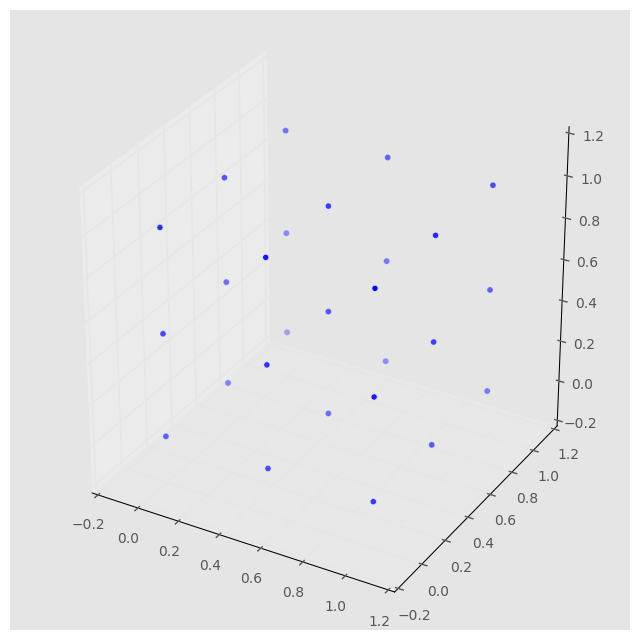

In [6]:
plot_3d(x0_i)

In [5]:
[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(X)

In [7]:
scale_factor

array([ 0.        ,  2.00000002])

In [8]:
(min(x_i.transpose()[0]) - scale_factor[0])/ scale_factor[1]

-4.8663942146626855

import timeit

start = timeit.default_timer()

[x0_i, scale_factor] = op.cartesian_scaling_to_unit_range(x_i)

stop = timeit.default_timer()

print(stop - start) 

In [9]:
# analytical answer
pair_potential = np.zeros(shape=(num_particles,num_particles)) 
for i in range(0, num_particles):
    for j in range(i+1, num_particles):
        pair_potential[i][j] = 1 / (op.distance_cal(x0_i[i], x0_i[j]) * scale_factor[1])
        
pair_potential

array([[ 0.        ,  1.        ,  0.5       ,  1.        ,  0.70710678,
         0.4472136 ,  0.5       ,  0.4472136 ,  0.35355339,  1.        ,
         0.70710678,  0.4472136 ,  0.70710678,  0.57735027,  0.40824829,
         0.4472136 ,  0.40824829,  0.33333333,  0.5       ,  0.4472136 ,
         0.35355339,  0.4472136 ,  0.40824829,  0.33333333,  0.35355339,
         0.33333333,  0.28867513],
       [ 0.        ,  0.        ,  1.        ,  0.70710678,  1.        ,
         0.70710678,  0.4472136 ,  0.5       ,  0.4472136 ,  0.70710678,
         1.        ,  0.70710678,  0.57735027,  0.70710678,  0.57735027,
         0.40824829,  0.4472136 ,  0.40824829,  0.4472136 ,  0.5       ,
         0.4472136 ,  0.40824829,  0.4472136 ,  0.40824829,  0.33333333,
         0.35355339,  0.33333333],
       [ 0.        ,  0.        ,  0.        ,  0.4472136 ,  0.70710678,
         1.        ,  0.35355339,  0.4472136 ,  0.5       ,  0.4472136 ,
         0.70710678,  1.        ,  0.40824829,  0.5773

In [10]:
J_analytic = np.zeros(num_particles)
for i in range(0, num_particles):
    for j in range(0, num_particles):
        if j<i:
            J_analytic[i] += pair_potential[j][i]
        if j>i:
            J_analytic[i] += pair_potential[i][j]

J_analytic

array([ 13.45603236,  15.02672924,  13.45603236,  15.02672924,
        16.88810287,  15.02672924,  13.45603236,  15.02672924,
        13.45603236,  15.02672924,  16.88810287,  15.02672924,
        16.88810287,  19.10408353,  16.88810287,  15.02672924,
        16.88810287,  15.02672924,  13.45603236,  15.02672924,
        13.45603236,  15.02672924,  16.88810287,  15.02672924,
        13.45603236,  15.02672924,  13.45603236])

In [11]:
total_energy = 0.5 * sum(J_analytic)
total_energy

204.20085524682005

In [12]:
from fast_multipole_method import fmm_level as fl
from fast_multipole_method import fmm_q_source as fq

In [13]:
# build list of q_source
q_source = np.ndarray(shape=(len(x0_i)), dtype=fq) 
for i in range(0, len(x0_i)):
    q_source[i] = fq(x0_i[i], q[i])

In [22]:
# run the calculation:
#1 construction of boxes at each level with Olm
btm_level = 3
p = 5
ws_index = 3
f_btm_level = fl(btm_level, q_source, p, ws_index)

f_top_level = f_btm_level
while (f_top_level.level != 1):
    print(f_top_level.level)
    f_top_level = f_top_level.lower_level_construction()
    
#2 calculation the interaction and translation the potential
print('----------')
f_level_i = f_top_level
while (f_level_i.level != f_btm_level.level):
    f_level_i.Mlm_translation_to_higher_level()
    f_level_i = f_level_i.higher_level
    print(f_level_i.level)
    f_level_i.box_interactions()
    
f_level_i.level

3
2
----------
2
3


3

In [23]:
#3 calculation of J far field
J_far_field = np.zeros(num_particles)
for i in range(0, num_particles):
    if not f_btm_level.box_list[q_source[i].box_id].Mlm:
        J_far_field[i] = 0.
    else:
        J_far_field[i] = f_btm_level.box_list[q_source[i].box_id].Mlm.product(q_source[i].Olm).sum().real 

J_far_field /= scale_factor[1]

In [24]:
J_far_field

array([  7.75736132,   9.32800819,  10.74887449,   9.32800819,
        11.18933432,  12.31952193,  10.74887449,  12.31952193,
        12.45592715,   9.32800819,  11.18933432,  12.31952193,
        11.18933432,  13.40526378,  14.18085371,  12.31952193,
        14.18085371,  14.02656945,  10.74887449,  12.31952193,
        12.45592715,  12.31952193,  14.18085371,  14.02656945,
        12.45592715,  14.02656945,  13.45586519])

In [25]:
#4 calculation of J near filed
J_near_field = np.zeros(num_particles)
for i in range(0,num_particles):
    J_near_field[i] = 0.
    for j in f_btm_level.box_list[q_source[i].box_id].q_source_id_set:
        if j == i:
            continue
        J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])
    for NN_box_id in f_btm_level.box_list[q_source[i].box_id].NN_box_id_set:
        for j in f_btm_level.box_list[NN_box_id].q_source_id_set:
            J_near_field[i] += 1  / (op.distance_cal(q_source[i].x, q_source[j].x) * scale_factor[1])

In [26]:
J_near_field

array([ 5.69867061,  5.69867061,  2.70710678,  5.69867061,  5.69867061,
        2.70710678,  2.70710678,  2.70710678,  1.        ,  5.69867061,
        5.69867061,  2.70710678,  5.69867061,  5.69867061,  2.70710678,
        2.70710678,  2.70710678,  1.        ,  2.70710678,  2.70710678,
        1.        ,  2.70710678,  2.70710678,  1.        ,  1.        ,
        1.        ,  0.        ])

In [27]:
J_total = J_far_field + J_near_field
J_total

array([ 13.45603193,  15.0266788 ,  13.45598127,  15.0266788 ,
        16.88800494,  15.02662871,  13.45598127,  15.02662871,
        13.45592715,  15.0266788 ,  16.88800494,  15.02662871,
        16.88800494,  19.10393439,  16.88796049,  15.02662871,
        16.88796049,  15.02656945,  13.45598127,  15.02662871,
        13.45592715,  15.02662871,  16.88796049,  15.02656945,
        13.45592715,  15.02656945,  13.45586519])

In [28]:
total_energy = 0.5 * sum(J_total)
total_energy

204.19948504734211

In [29]:
J_error = np.abs(J_total-J_analytic) / J_analytic
J_error

array([  3.23366916e-08,   3.35617822e-06,   3.79679240e-06,
         3.35617822e-06,   5.79893261e-06,   6.68964197e-06,
         3.79679240e-06,   6.68964197e-06,   7.81895926e-06,
         3.35617822e-06,   5.79893261e-06,   6.68964197e-06,
         5.79893261e-06,   7.80643554e-06,   8.43078576e-06,
         6.68964197e-06,   8.43078576e-06,   1.06337126e-05,
         3.79679240e-06,   6.68964197e-06,   7.81895926e-06,
         6.68964197e-06,   8.43078576e-06,   1.06337126e-05,
         7.81895926e-06,   1.06337126e-05,   1.24239345e-05])

In [30]:
J_error[1:50]

array([ 0.69741252,  0.57124546,  0.69741252,  0.56177968,  0.47849143,
        0.57124546,  0.47849143,  0.37189532,  0.69741252,  0.56177968,
        0.47849143,  0.56177968,  0.40870691,  0.37576764,  0.47849143,
        0.37576764,  0.29825829,  0.57124546,  0.47849143,  0.37189532,
        0.47849143,  0.37576764,  0.29825829,  0.37189532,  0.29825829,
        0.21003289])